In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, make_scorer
import sklearn

In [4]:
import matplotlib as mpl
warnings.simplefilter('ignore')

# Пролистать до набора Марата

In [5]:
d=np.load('2021-11-17.npz')

In [6]:
d.files

['X', 'Y', 'Em', 'Ex', 'B0', 'C0']

In [7]:
X=d['X']

In [8]:
X*=1e7

In [9]:
y=d['Y'][:,2]

In [10]:
X -= X.mean(axis = 0)

In [11]:
y*=1e1

In [12]:
y -= y.mean()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1428, random_state=42)

In [14]:
X_train.shape

(54, 351, 35)

In [15]:
X.shape

(64, 351, 35)

In [16]:
tr=[1,-8,-9,9,8,-7]

In [17]:
np.sign(tr)

array([ 1, -1, -1,  1,  1, -1])

# Опробую на наборе Марата

In [88]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X_new.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))

In [89]:
import  subprocess
import sys
import os
from N_PLS1_help_scripts.CenteringClass import centrir

In [90]:
cen=centrir(testSize=0.1428,column_y=0)
result=cen.centering_and_cv(Xdata_numpy['X'],Ydata)
y_train=result.y_train
y_test=result.y_test
X_train=result.X_train
X_test=result.X_test

In [136]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2,a=3,b_l1_k=0,b_l1_i=0):
        self.n_components = n_components
        self.a=a
        self.b_l1_k=b_l1_k
        self.b_l1_i=b_l1_i
    
    def l1_func(self,w,const_):
        w1=np.absolute(w)
        for i in range(w1.shape[0]):
            if w1[i]<=const_:
                w1[i]=0
        return w1
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        
        mmas=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
        z_pz=np.eye(x.shape[1])
        z_z=z_pz[:,:x.shape[2]]
        
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=y[i]*x[i,:,:]
            z=x_product.sum(axis=0)
            
            # Блок регуляризации z
            #z_po=LA.pinv(z)
            #z=np.dot((np.dot(z,z_po)+(self.a*np.eye(z.shape[0]))),z)
            
            
            Wk, S, WI = np.linalg.svd(z)
            #plt.imshow(Wk, aspect='auto')
            #plt.imshow(WI, aspect='auto')
            #plt.imshow(S, aspect='auto')
            #plt.show();
            w_k=np.array(Wk[:,0]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            
            # Вставим L1-регуляризацию
            
            #plt.plot(w_k,color="red")
            #plt.plot(np.absolute(w_k)-self.b_l1, color="green")
            w_k_max=np.max(np.absolute(w_k))
            w_i_max=np.max(np.absolute(w_i))
            w_k=np.multiply(np.sign(w_k),self.l1_func(w_k,w_k_max*self.b_l1_k))
            w_i=np.multiply(np.sign(w_i),self.l1_func(w_i,w_i_max*self.b_l1_i))
            
            #plt.plot(w_k,color="blue")
            #plt.plot(w_k, color="orange")
            #plt.show()
            
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_i.transpose(),x[h,:,:].transpose()),w_k)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)        
            #print(T)
            #print((np.dot(np.linalg.inv(np.dot(T,T.transpose())+(self.a*np.eye(x.shape[0]))),T)).shape)
            
            #print(T.shape)
            T_T_a=np.dot(T,T.transpose())-(((self.a/(10*f+1)))*np.eye(x.shape[0]))
            T_a_1=np.linalg.inv(T_T_a)
            bf=np.dot((np.dot(T_a_1,T)).transpose(),
                      y.reshape([x.shape[0],1]))
            #print(T.shape)
            #l1_ar=np.sign(bf)
            
            #tr1=l1_ar*self.b_l1
            #tr2=np.dot(T_a_1,tr1)
            #print(tr2.shape)
            
            #print(l1_ar.shape)
            #print(l1_ar)
            #print(bf.shape) #(self.a/(f+1)
            #print((np.dot(T,bf)).shape).reshape(x.shape[1],x.shape[2])
            bf_array+=[bf]
            #plt.plot(bf)
            #plt.show();
            
            WW=np.kron(w_k,w_i).reshape(x.shape[1],x.shape[2])
            for g in range(0,x.shape[0]):
                mmas[g,:,:]=Tt[g,f]*WW
            #mmas=np.kron(Tt[:,f],WW).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=np.array(x-(mmas)) 
            #plt.imshow(mmas[5,:,:], aspect='auto')
            #plt.show();
            #for g in range(0,x.shape[0]):
            
            #plt.imshow(np.kron(w_k,w_i).reshape(x.shape[1],x.shape[2]), aspect='auto')
            #plt.show();
            
            Y_m=(np.dot(T,bf)).reshape(x.shape[0])
            #plt.plot(Y_m, color="red")
            #plt.plot(y_copy, color="blue")
            
            y=(y-(np.dot(T,bf)).reshape(x.shape[0]))
            
            #plt.plot(y, color="green")
    
            #print(y)
            mass+=(np.dot(T,bf)).reshape(x.shape[0]).reshape(x.shape[0])
            #plt.plot(mass, color="yellow")
            #plt.show();
            bf=0
            
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        
        return self
    
    #def fit_transform(self,x.copy()):
        """"
        Даже для 20 компонент функция fit работает быстро, а вот функция predict нет.
        Кроме того, некоторые вычислительные операции требуют колоссальных 
        объёмов памяти, поэтому, сначала нужно провести анализ нагрузок и 
        трансформацию данных в форму поменьше.
        
        Отбор длин волн я решил делать при помощи поглощающих жадных алгоритмов поиска. SBS алгоритм.
        """
    
    def predict(self, xx):
        x=xx.copy()
        Tt=np.zeros([x.shape[0],self.n_components])
        #y=np.random.normal(loc=0,scale=10,size=x.shape[0])
        y=np.zeros([x.shape[0]])
        mmas=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
        for f in range(0,self.n_components):
            w_k=self.w_k[f,:,:]
            w_i=self.w_i[f,:,:]
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_i.transpose(),x[h,:,:].transpose()),w_k)
            
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            #bf=np.dot((np.dot(np.linalg.inv(np.dot(T,T.transpose())),T)).transpose(),
            #              y.reshape([x.shape[0],1]))
            WW=np.kron(w_k,w_i).reshape(x.shape[1],x.shape[2])
            #plt.imshow(WW, aspect='auto')
            #plt.show();
            for g in range(0,x.shape[0]):
                #mmas[g,:,:]=Tt[g,f]*WW
                mmas[g,:,:]=Tt[g,f]*WW
            x=np.array(x-(mmas))
            #print(len(np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2]))))
            #print()
            #plt.plot(self.bf_array[f])
            #plt.show();
            
            #bf=np.dot((np.dot(np.linalg.inv(np.dot(T,T.transpose())-(self.a*np.eye(x.shape[0]))),T)).transpose(),
             #             y.reshape([x.shape[0],1]))
            
            y=(y+(np.dot(T,self.bf_array[f])).reshape(x.shape[0]))
            #y=(y+(np.dot(T,bf)).reshape(x.shape[0]))
        
        return y
            
         

In [197]:
npls1=Tri_PLS1_grid()
scoring={'mse': make_scorer(mean_squared_error),'r2':'r2'}
parametrsNames={'n_components': [3],
                'a': [0.1],
                'b_l1_k':[0.9,0],
                'b_l1_i':[0.01,0]}

In [198]:
%%time
gridCought=GridSearchCV(npls1, parametrsNames, cv=3, scoring=scoring,refit='r2', return_train_score=True)
gridCought.fit(X_train.copy(),y_train.copy())
r2_p=gridCought.score(X_test.copy(), y_test.copy())
mse_cv=gridCought.cv_results_[ "mean_test_mse" ]
mse_c=gridCought.cv_results_[ "mean_train_mse" ]
r2_cv=gridCought.cv_results_[ "mean_test_r2" ]
r2_c=gridCought.cv_results_[ "mean_train_r2" ]
#predictors=gridCought.predict(X_test.copy())

Wall time: 1.38 s


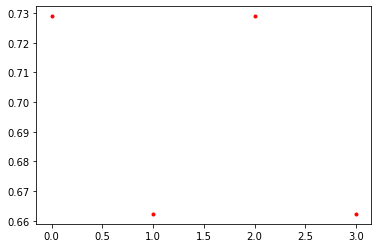

In [199]:
#plt.plot(r2_p,".",color='green')
#plt.plot(r2_c,".",color='blue')
plt.plot(r2_cv,".",color='red')
plt.show()

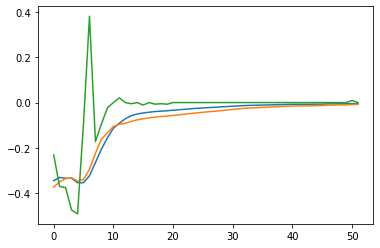

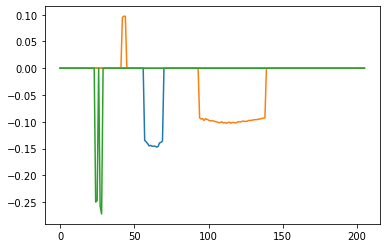

In [195]:
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

plt.figure()
plt.plot(flatten(gridCought.best_estimator_.w_i).transpose())

plt.figure()
plt.plot(flatten(gridCought.best_estimator_.w_k).transpose())


In [196]:
gridCought.best_params_

{'a': 0.1, 'b_l1_i': 0.01, 'b_l1_k': 0.9, 'n_components': 3}

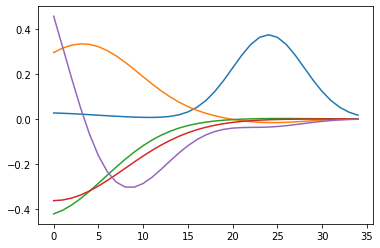

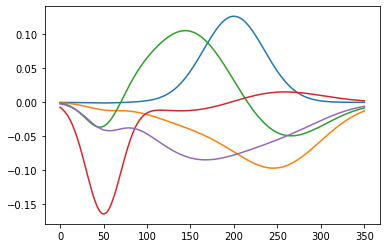

In [32]:
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

plt.figure()
plt.plot(flatten(gridCought.best_estimator_.w_i).transpose())

plt.figure()
plt.plot(flatten(gridCought.best_estimator_.w_k).transpose())
